# Discovering QM

In [33]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrandom

import optax
import diffrax
import equinox as eqx

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [34]:
def potential(x, rho, args):
    return args['V_barrier']*0.25*(jnp.tanh((x+args['barrier_width'])/(0.2*args['barrier_width'])) + 1.0)*(jnp.tanh(-(x-args['barrier_width'])/(0.2*args['barrier_width'])) + 1.0)

def classical_force(x, rho, args):
    return -jax.vmap(jax.grad(potential),in_axes=[0,None,None])(x,rho,args)

In [35]:
def bin_particles(xs, args):
    dx, Nx, Np = args['dx'], args['Nx'], args['Np']
    # Assuming the grid starts at args['xcs'][0]. 
    # If args['xcs'] is just 0, dx, 2dx... then x_start is args['xcs'][0]
    x_start = args['xcs'][0]

    # 1. Normalize positions to grid units
    # This converts physical position x to continuous grid index u
    u = (xs - x_start) / dx
    
    # 2. Identify the nearest grid point (center index)
    # The shape function is centered on the nearest grid point
    center_idx = jnp.round(u).astype(int)
    
    # 3. Calculate distance from center (delta) in normalized units
    # delta ranges roughly from -0.5 to 0.5
    d = u - center_idx

    # 4. Compute Weights (Quadratic Spline)
    # These match your mathematical conditions exactly, but vectorized
    # Center weight (condition: |x-grid| <= dx/2)
    w_center = 0.75 - d**2
    
    # Left neighbor weight (condition: dx/2 < |x-grid| <= 3dx/2)
    # Derived from 0.5 * (1.5 - |dist|)**2
    w_left = 0.5 * (0.5 - d)**2
    
    # Right neighbor weight
    w_right = 0.5 * (0.5 + d)**2

    # 5. Prepare Indices and Weights for Scatter
    # We stack them to process all 3 contributions at once
    weights = jnp.stack([w_left, w_center, w_right], axis=1).flatten()
    indices = jnp.stack([center_idx - 1, center_idx, center_idx + 1], axis=1).flatten()

    # 6. Scatter-Add
    # We start with an empty grid and add weights at the calculated indices.
    # mode='drop' ensures particles near the boundary don't crash the code if they look outside [0, Nx]
    rho = jnp.zeros(Nx).at[indices].add(weights, mode='drop')
    
    # Apply the scaling factors from your original code
    rho = rho * (1 / dx) / Np
    
    return rho

def particle_push(x, v, force_func, args):
    dxdt = v
    rho = bin_particles(x, args)
    dvdt = force_func(x,rho,args) / args['m']
    return dxdt, dvdt

In [36]:
def DiffraxWrapper(force_func):
    def _wrap(t,y,args):
        y_reshape = y.reshape(args['Np'], 2)
        x = y_reshape[:, 0]
        v = y_reshape[:, 1]
        d_x_dt, d_v_dt = particle_push(x, v, force_func, args)
        return jnp.stack([d_x_dt, d_v_dt], axis=-1).reshape(args['Np']*2)
    return _wrap

In [37]:
def init_x_and_v(key, args):
    x0 = jrandom.normal(key, shape=(args['Np'],)) * args['x0_width'] + args['x0_center']
    v0 = jnp.ones_like(x0) * args['v0']
    return x0, v0

def savefn(t, y, args):
    ys = y.reshape(args['Np'], 2)
    xs = ys[:,0]
    vs = ys[:,1]
    rhos = bin_particles(xs,args)
    return dict(xs=xs, vs=vs, rhos=rhos)

In [38]:
Np = int(1e5)

x_min = -5.0
x_max = 4.0
Nx = 300
xbins = jnp.linspace(x_min, x_max, Nx+1)
xcs = 0.5 * (xbins[:-1] + xbins[1:])

t0 = 0.0
t1 = 4.0
Nt = 100
dt0 = 5e-2

equation = DiffraxWrapper(classical_force)
term = diffrax.ODETerm(equation)
solver = diffrax.Heun()
stepsize_controller = diffrax.ConstantStepSize()

args = {
    't0': t0,
    't1': t1,
    'Nt': Nt,
    'dt0': dt0,
    'x0_center': -2.0,
    'x0_width': 0.5,
    'v0' : 1.0,
    'm': 1.0,
    'Np': Np,
    'Nx': Nx,
    'x_min': x_min,
    'x_max': x_max,
    'xbins': xbins,
    'xcs' : xcs,
    'dx' : xcs[1] - xcs[0],
    'V_barrier': 0.25,
    'barrier_width': 0.25,
}

# At what time points you want to save the solution
saveat = diffrax.SaveAt(ts=jnp.linspace(t0,t1,Nt), fn = savefn)

key = jrandom.PRNGKey(420)

x0, v0 = init_x_and_v(key, args)
y0 = jnp.stack([x0, v0], axis=-1).reshape(-1)

solution = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=y0,
    args=args,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=int(1e7),
)

In [39]:
%load_ext autoreload
%autoreload 2
from QMSolver import get_QM_solution
P_QM, _ = get_QM_solution(args, potential)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


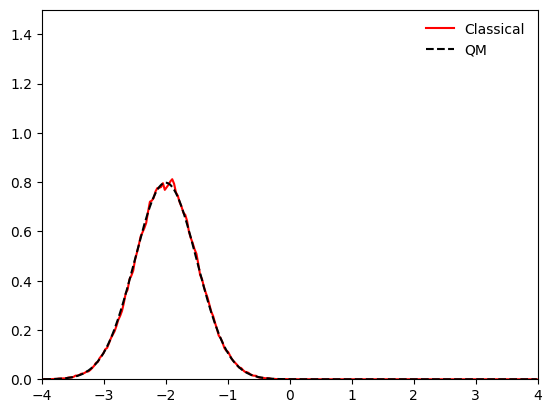

In [40]:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation

fig, ax = plt.subplots()
ax.axis([-4,4,0,1.5])
l1, = ax.plot([],[],'r',label='Classical')
l2, = ax.plot([],[],'k',ls='--',label='QM')

ax.legend(frameon=False,loc=1)

def animate(i):
    l1.set_data(xcs, solution.ys['rhos'][i,:])
    l2.set_data(xcs, P_QM[i,:])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt, interval = 50)
ani

In [ ]:
class Smoother(eqx.Module):
    n: int

    def __call__(self, x, *args, **kwargs):
        return jnp.convolve(x, jnp.ones(self.n)/self.n, mode="same")

class FiniteDifferenceLayer(eqx.Module):
    dx: float
    smoother: Smoother

    def __init__(self, dx, window):
        self.dx = dx
        self.smoother = Smoother(window)

    def __call__(self, x, *args, **kwargs):
        _x = self.smoother(x)
        _diffx = jnp.diff(_x,prepend=0) / self.dx
        _diff2x = jnp.diff(self.smoother(_diffx),prepend=0) / self.dx
        u = jnp.concatenate([_x,_diffx,_diff2x])
        return u

class QMBohmForce(eqx.Module):
    model: eqx.nn.MLP
    classical_potential: callable

    def __init__(self, classical_potential, size, hidden_size, depth, initial_smooth_window, final_smooth_window, args, *, key, **kwargs):
        super().__init__(**kwargs)
        self.classical_potential = classical_potential

        layers = [eqx.nn.Lambda(FiniteDifferenceLayer(args['dx'], initial_smooth_window))]
        for i in range(depth-1):
            key, subkey = jrandom.split(key)
            if i == 0:
                layers.append(eqx.nn.Linear(3*size,hidden_size,key=subkey))
            else:
                layers.append(eqx.nn.Linear(hidden_size,hidden_size,key=subkey))
            layers.append(eqx.nn.Lambda(jax.nn.leaky_relu))
        key, subkey = jrandom.split(key)
        layers.append(eqx.nn.Linear(hidden_size,size,key=subkey,use_bias=False))
        layers.append(eqx.nn.Lambda(Smoother(final_smooth_window)))
        base_model = eqx.nn.Sequential(layers)

        # Initialize the final linear layer to zero to start with no quantum potential
        where = lambda m: m.layers[-2].weight
        self.model = eqx.tree_at(where, base_model, jnp.zeros_like(base_model.layers[-2].weight))

    def quantum_force(self, x, rho, args):
        Fq = self.model(rho)
        return jnp.interp(x, args['xcs'], Fq)

    def total_force(self, x, rho, args):
        FClassical = -jax.vmap(jax.grad(self.classical_potential),in_axes=[0,None,None])(x,rho,args)
        FQuantum = self.quantum_force(x,rho,args)
        return FClassical + FQuantum
    
    def __call__(self, args):
        qm_equation = DiffraxWrapper(self.total_force)
        qm_term = diffrax.ODETerm(qm_equation)
        solution = diffrax.diffeqsolve(
            qm_term,
            solver,
            t0=args['t0'],
            t1=args['t1'],
            dt0=args['dt0'],
            y0=y0,
            args=args,
            saveat=saveat,
            stepsize_controller=stepsize_controller,
            max_steps=int(1e7),
        )
        return solution.ys['rhos']

In [47]:
def train_QMBohmForce(qm_force, args, QM_Ps, num_epochs, learning_rate, print_every=10):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(qm_force, eqx.is_inexact_array))

    def loss_fn(qm_force):
        rhos = qm_force(args)
        loss = jnp.mean((rhos - QM_Ps)**2)
        return loss
    
    @eqx.filter_jit
    def update(qm_force, opt_state):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(qm_force)
        updates, opt_state = optimizer.update(grads, opt_state)
        qm_force = eqx.apply_updates(qm_force, updates)
        return qm_force, opt_state, loss

    history = []
    for epoch in range(num_epochs):
        qm_force, opt_state, loss = update(qm_force, opt_state)
        if epoch % print_every == 0:
            print(f"Epoch {epoch}, Loss: {loss}")
        history.append(loss)
    
    return qm_force, history

In [52]:
def model_filename(model_args):
    return f'qm_force_h={model_args['hidden_size']}_d={model_args['depth']}_is={model_args['initial_smooth_window']}_fs={model_args['final_smooth_window']}.eqx'

In [53]:
model_args = dict(hidden_size=64, depth=2, initial_smooth_window=12, final_smooth_window=6)

In [ ]:
subkey, _ = jrandom.split(key)
reset = True
trained_qm_force = QMBohmForce(potential, size=args['Nx'], **model_args, key=subkey, args=args)
if not reset:
    trained_qm_force = eqx.tree_deserialise_leaves(model_filename(model_args), trained_qm_force)

In [49]:
trained_qm_force, history = train_QMBohmForce(trained_qm_force, args, P_QM, num_epochs=1000, learning_rate=1e-4, print_every=1)

Epoch 0, Loss: 0.0025117443401811742
Epoch 1, Loss: 0.0023796245683323754
Epoch 2, Loss: 0.0022461751761886886
Epoch 3, Loss: 0.0021110393630990364
Epoch 4, Loss: 0.001975661445017813
Epoch 5, Loss: 0.0018418658476174314
Epoch 6, Loss: 0.001711607932952502
Epoch 7, Loss: 0.0015867793917829366
Epoch 8, Loss: 0.001469303791159595
Epoch 9, Loss: 0.0013609019435125696
Epoch 10, Loss: 0.001262989592630667
Epoch 11, Loss: 0.001176446864559867
Epoch 12, Loss: 0.0011017592967770325
Epoch 13, Loss: 0.0010387994117637433
Epoch 14, Loss: 0.0009867100838072452
Epoch 15, Loss: 0.0009443545984663159
Epoch 16, Loss: 0.0009098522354967942
Epoch 17, Loss: 0.00088085803145208
Epoch 18, Loss: 0.0008550252575266523
Epoch 19, Loss: 0.0008303559701136259
Epoch 20, Loss: 0.0008052983143441933
Epoch 21, Loss: 0.0007791002003479475
Epoch 22, Loss: 0.0007519076902057483
Epoch 23, Loss: 0.0007245629809521357
Epoch 24, Loss: 0.0006982220466756619
Epoch 25, Loss: 0.0006741962910016239
Epoch 26, Loss: 0.00065353352

In [54]:
save = True
if save:
    eqx.tree_serialise_leaves(model_filename(model_args),trained_qm_force)

In [50]:
trained_qm_rhos = trained_qm_force(args)

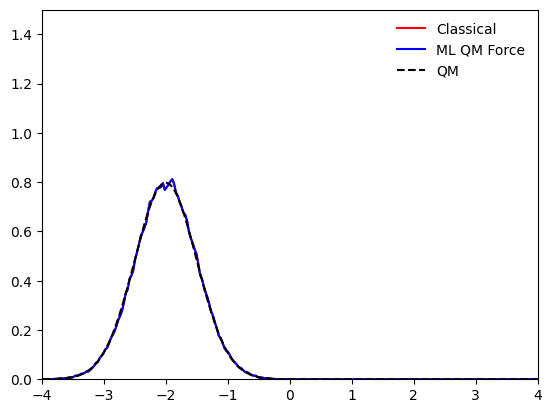

In [51]:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation

fig, ax = plt.subplots()
ax.axis([-4,4,0,1.5])
l1, = ax.plot([],[],'r',label='Classical')
l2, = ax.plot([],[],'b',label='ML QM Force')
l3, = ax.plot([],[],'k',ls='--',label='QM')

ax.legend(frameon=False,loc=1)

def animate(i):
    l1.set_data(xcs, solution.ys['rhos'][i,:])
    l2.set_data(xcs, trained_qm_rhos[i,:])
    l3.set_data(xcs, P_QM[i,:])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt, interval = 50)
ani

writer = matplotlib.animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('LearningQM.gif', writer=writer)


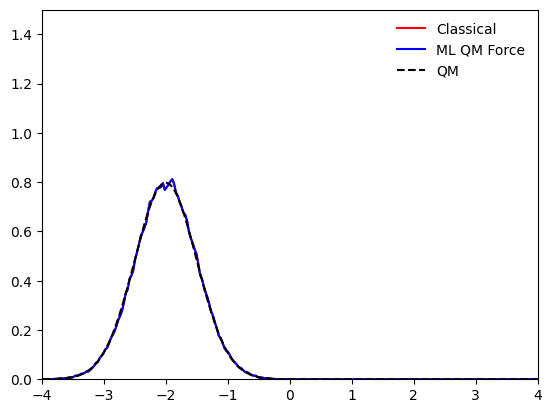

In [46]:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation

fig, ax = plt.subplots()
ax.axis([-4,4,0,1.5])
l1, = ax.plot([],[],'r',label='Classical')
l2, = ax.plot([],[],'b',label='ML QM Force')
l3, = ax.plot([],[],'k',ls='--',label='QM')

ax.legend(frameon=False,loc=1)

def animate(i):
    l1.set_data(xcs, solution.ys['rhos'][i,:])
    l2.set_data(xcs, trained_qm_rhos[i,:])
    l3.set_data(xcs, P_QM[i,:])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt, interval = 50)

writer = matplotlib.animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('LearningQM.gif', writer=writer)


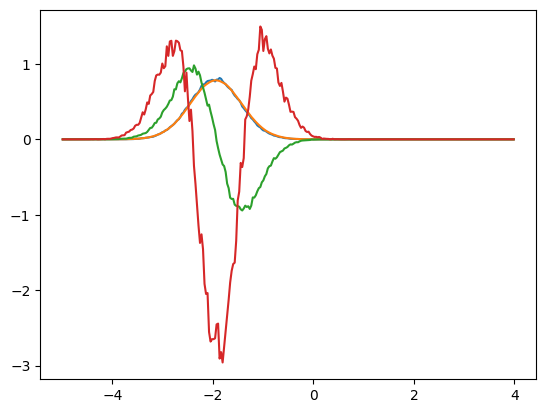

In [45]:
it = 1

smoother = Smoother(12)

plt.plot(xcs,solution.ys['rhos'][it,:])
plt.plot(xcs,smoother(solution.ys['rhos'][it,:]))

drhodx = jnp.diff(smoother(solution.ys['rhos'][it,:]),prepend=0)/args['dx']
plt.plot(xcs,drhodx)

d2rhodx2 = jnp.diff(smoother(drhodx),prepend=0,n=1)/args['dx']
plt.plot(xcs,d2rhodx2)